<a href="https://colab.research.google.com/github/mateuszbarnacki/SSN-Proj/blob/main/SSN_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importy**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
!pip install tensorflow-addons==0.10.0
import tensorflow_addons
from tensorflow_addons.layers import MultiHeadAttention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


**Przygotowanie danych wejściowych**

In [ ]:
data = pd.read_csv("COVID-19 w Polsce - Wzrost.csv", header=None)
data = data.values[2:-1,1]
data = np.array([x[2:] for x in data]).astype(int)

# !pip install tensorflow_datasets
# !pip install -U 'tensorflow-text==2.8.*'

train_data, val_data = data[:700], data[700:]

def linear(x):
  return x

**Architektura modelu**

In [ ]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name='Time2VecLayer')
        self.k = kernel_size
    
    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name='wb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        self.bb = self.add_weight(name='bb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        # periodic
        self.wa = self.add_weight(name='wa',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        self.ba = self.add_weight(name='ba',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp)

        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1]*(self.k+1)))
        return ret
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*(self.k + 1))

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_dense1 = keras.layers.Dense(64, activation='sigmoid')
        self.ff_dense2 = keras.layers.Dense(1, activation=linear)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)

        x = self.ff_conv1(x)
        x = self.ff_conv2(x)
        x = self.ff_dropout(x)
        x = self.ff_norm(inputs + x)

        x = self.ff_dense1(x)
        x = self.ff_dense2(x)

        return x

class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', time2vec_dim=1, num_heads=2, head_size=128, ff_dim=None, num_layers=1, dropout=0, **kwargs):
      super().__init__(name=name, **kwargs)
      self.time2vec = Time2Vec(kernel_size=time2vec_dim)
      if ff_dim is None:
          ff_dim = head_size
      self.dropout = dropout
      self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]

        
    def call(self, inputs):
        time_embedding = keras.layers.TimeDistributed(self.time2vec)(inputs) 

        x = K.concatenate([inputs, time_embedding], -1) 

        for attention_layer in self.attention_layers:
            x = attention_layer(x) 

        return K.reshape(x, (-1, x.shape[1] * x.shape[2]))

**Przygotowanie danych z uwzględnieniem ilości dni po jakich następuje predykcja przypadków choroby**

In [ ]:
def prepare_X_y(data):
  X_data = []
  y_data = []
  for i in range(len(data)-NR_DAYS):
    X = []
    for j in range(NR_DAYS):
      X.append(data[i+j] / MAX_DATA)
    X_data.append(np.array(X))
    y_data.append(data[i+NR_DAYS] / MAX_DATA)

  X_data = np.array(X_data).reshape(len(X_data),NR_DAYS,1).astype(float)
  y_data = np.array(y_data).reshape(len(y_data),1,1).astype(float)

  return X_data, y_data

**Funkcje pomocnicze do analizy danych**

In [ ]:
def prepare_preds(X):
  y_preds = []
  for x in X:
    X_pred = np.array(x).reshape(1,NR_DAYS,1).astype(float)
    y_pred = model.predict(X_pred) * MAX_DATA
    y_preds.append(y_pred[0][-3])
  return y_preds

def draw_predictions(nr_epochs, y_test, y_preds, title, figure_name):
    epochs = np.arange(nr_epochs)
    plt.figure(figsize=(12,4))

    plt.plot(epochs, y_test, "r")
    plt.plot(epochs, y_preds, "g")
    
    plt.ylabel("Ilość przypadków")
    plt.xlabel('Czas')
    plt.legend(['true', 'pred'], loc='best')
    plt.title("Przewidywania liczby przypadków dla danych " + title)
     
    plt.savefig(figure_name)
    plt.show()

**Funkcje miary błędu**

In [ ]:
def det_coeff(y_true, y_pred):
  SS_res = K.sum(K.square(y_true - y_pred))
  SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
  return (1. - SS_res/(SS_tot + K.epsilon()))

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def accuracy_m(y_true, y_pred):
  correct_preds = 0
  for i in range(len(y_pred)):
    if y_true[i] == y_pred[i]:
      correct_preds = correct_preds + 1
  return correct_preds / len(y_pred)

def idx_of_agreement(y_true, y_pred):
  up = K.sum(K.square(y_true - y_pred))
  down = K.sum(K.square(K.abs(y_pred - K.mean(y_true)) + (K.abs(y_true - K.mean(y_true)))))
  return (1. - up / (down + K.epsilon()))

def mean_squared_error(y_true, y_pred):
  return K.mean(K.square(y_pred - y_true), axis=0)

def mean_absolute_error(y_true, y_pred):
  return K.mean(K.abs(y_pred - y_true), axis=0)

**Normalizacja danych oraz ustalenie ilości dni, na podstawie której zostanie dokonana predykcja ilości przypadków**

In [ ]:
MAX_DATA = np.max(data)
NR_DAYS = 10

**Działanie modelu przy użyciu odgórnego podziału danych na uczące i testujące**

Rozmiar danych uczących: 700.

Rozmiar danych testowych: 39.

Epoch 1/50
22/22 [==============================] - 3s 153ms/step - loss: 0.0231 - val_loss: 0.0174
Epoch 2/50
22/22 [==============================] - 5s 211ms/step - loss: 0.0114 - val_loss: 0.0149
Epoch 3/50
22/22 [==============================] - 5s 235ms/step - loss: 0.0084 - val_loss: 0.0119
Epoch 4/50
22/22 [==============================] - 6s 254ms/step - loss: 0.0071 - val_loss: 0.0116
Epoch 5/50
22/22 [==============================] - 6s 282ms/step - loss: 0.0065 - val_loss: 0.0134
Epoch 6/50
22/22 [==============================] - 6s 270ms/step - loss: 0.0065 - val_loss: 0.0143
Epoch 7/50
22/22 [==============================] - 3s 118ms/step - loss: 0.0060 - val_loss: 0.0191
Epoch 8/50
22/22 [==============================] - 3s 118ms/step - loss: 0.0058 - val_loss: 0.0169
Epoch 9/50
22/22 [==============================] - 3s 115ms/step - loss: 0.0059 - val_loss: 0.0208
Epoch 9: early stopping


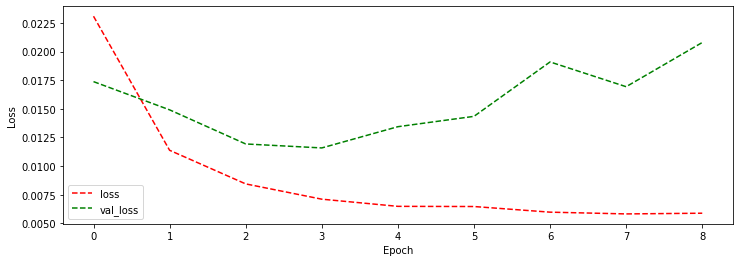

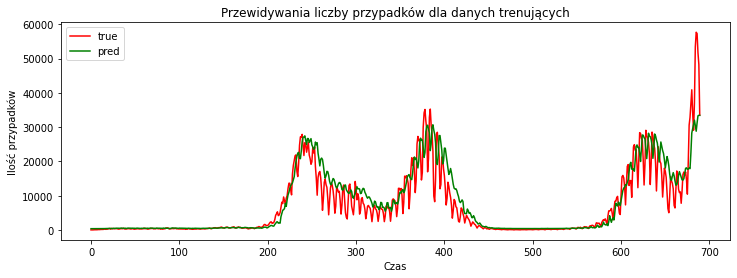

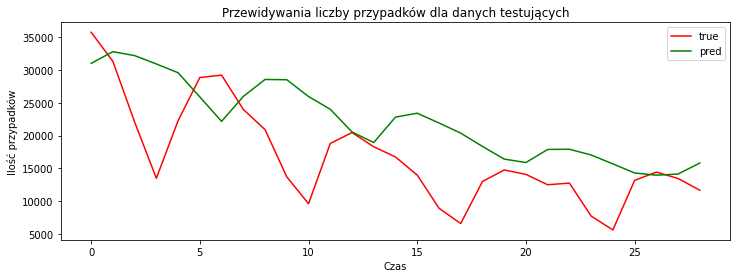

Coefficient of determination: -0.1987822
Index of agreement: 0.6809993
Recall: 1.0
Accuracy: 0.0


In [ ]:
X_train, y_train = prepare_X_y(train_data)

X_test, y_test = prepare_X_y(val_data)

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

EarlyStop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1)

callbacks = [EarlyStop]

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

# Wypisanie predykowanych wartości w formie liczbowej
# X_pred = np.array(X_train[-1]).reshape(1,NR_DAYS,1).astype(float)
# print(X_pred * MAX_DATA)
# y_pred = model.predict(X_pred) * MAX_DATA
# print(y_pred.shape)
# print(y_pred)
# print(np.max(y_pred[0][-3:]))

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], "r--")
plt.plot(history.history['val_loss'], "g--")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.savefig('divided_loss.png')
plt.show()

y_preds = prepare_preds(X_train)
draw_predictions(len(y_preds), y_train.reshape(len(y_preds)) * MAX_DATA, y_preds, "trenujących", "divided_train.png")
y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących", "divided_test.png")

y = y_test * MAX_DATA
y = np.reshape(y, len(y))
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
acc = accuracy_m(y, y_preds)
#mse = mean_squared_error(K.constant(y), K.constant(y_preds))
#mae = mean_absolute_error(K.constant(y), K.constant(y_preds))
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
#print('Mean square error: ' + str(K.get_value(mse)))
#print('Mean absolute error: ' + str(K.get_value(mae)))
print('Recall: ' + str(K.get_value(recall)))
print('Accuracy: ' + str(acc))

**Podział danych za pomocą Time Series Split**

**Ilość podziałów: 5**

Epoch 1/50
18/18 [==============================] - 3s 160ms/step - loss: 0.0234 - val_loss: 0.1034
Epoch 2/50
18/18 [==============================] - 4s 240ms/step - loss: 0.0132 - val_loss: 0.0406
Epoch 3/50
18/18 [==============================] - 5s 266ms/step - loss: 0.0056 - val_loss: 0.0372
Epoch 4/50
18/18 [==============================] - 5s 265ms/step - loss: 0.0044 - val_loss: 0.0302
Epoch 5/50
18/18 [==============================] - 7s 363ms/step - loss: 0.0038 - val_loss: 0.0298
Epoch 6/50
18/18 [==============================] - 6s 307ms/step - loss: 0.0035 - val_loss: 0.0271
Epoch 7/50
18/18 [==============================] - 4s 199ms/step - loss: 0.0032 - val_loss: 0.0255
Epoch 8/50
18/18 [==============================] - 2s 136ms/step - loss: 0.0031 - val_loss: 0.0247
Epoch 9/50
18/18 [==============================] - 2s 138ms/step - loss: 0.0030 - val_loss: 0.0246
Epoch 10/50
18/18 [==============================] - 2s 132ms/step - loss: 0.0031 - val_loss: 0.0256

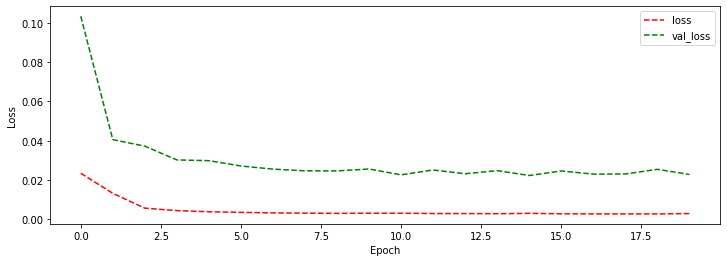

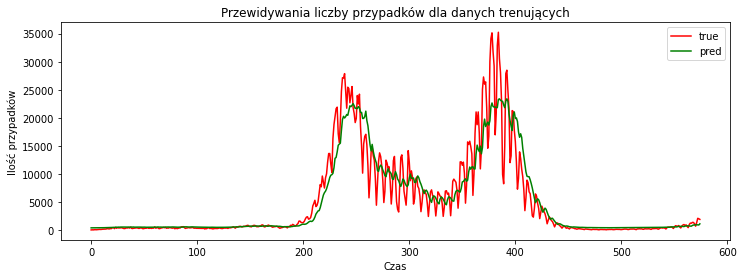

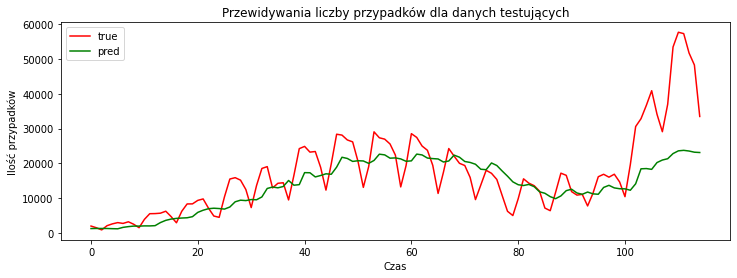

Coefficient of determination: 0.46471828
Index of agreement: 0.772749
Recall: 1.0
Accuracy: 0.0


In [ ]:
X, y = prepare_X_y(train_data)

tscv = TimeSeriesSplit(n_splits=5)
#print(tscv)

for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

EarlyStop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1)

callbacks = [EarlyStop]

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

# Wypisanie predykowanych wartości w formie liczbowej
# X_pred = np.array(X_train[-1]).reshape(1,NR_DAYS,1).astype(float)
# print(X_pred * MAX_DATA)
# y_pred = model.predict(X_pred) * MAX_DATA
# print(y_pred.shape)
# print(y_pred)
# print(np.max(y_pred[0][-3:]))

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], "r--")
plt.plot(history.history['val_loss'], "g--")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.savefig('time_series_5_loss.png')
plt.show()

y_preds = prepare_preds(X_train)
draw_predictions(len(y_preds), y_train.reshape(len(y_preds)) * MAX_DATA, y_preds, "trenujących", "time_series_5_train.png")
y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących", "time_series_5_test.png")

y = y_test * MAX_DATA
y = np.reshape(y, len(y))
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
acc = accuracy_m(y, y_preds)
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Recall: ' + str(K.get_value(recall)))
print('Accuracy: ' + str(acc))

**Ilość podziałów: 10**

Epoch 1/50
20/20 [==============================] - 3s 125ms/step - loss: 0.4626 - val_loss: 0.3157
Epoch 2/50
20/20 [==============================] - 3s 126ms/step - loss: 0.0283 - val_loss: 0.0843
Epoch 3/50
20/20 [==============================] - 2s 121ms/step - loss: 0.0242 - val_loss: 0.1149
Epoch 4/50
20/20 [==============================] - 2s 123ms/step - loss: 0.0181 - val_loss: 0.1347
Epoch 5/50
20/20 [==============================] - 3s 126ms/step - loss: 0.0168 - val_loss: 0.1216
Epoch 6/50
20/20 [==============================] - 2s 125ms/step - loss: 0.0122 - val_loss: 0.0965
Epoch 7/50
20/20 [==============================] - 3s 130ms/step - loss: 0.0076 - val_loss: 0.0739
Epoch 8/50
20/20 [==============================] - 3s 127ms/step - loss: 0.0054 - val_loss: 0.0607
Epoch 9/50
20/20 [==============================] - 2s 122ms/step - loss: 0.0043 - val_loss: 0.0538
Epoch 10/50
20/20 [==============================] - 3s 126ms/step - loss: 0.0041 - val_loss: 0.0506

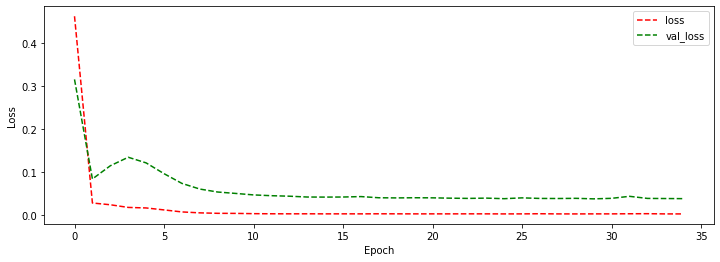

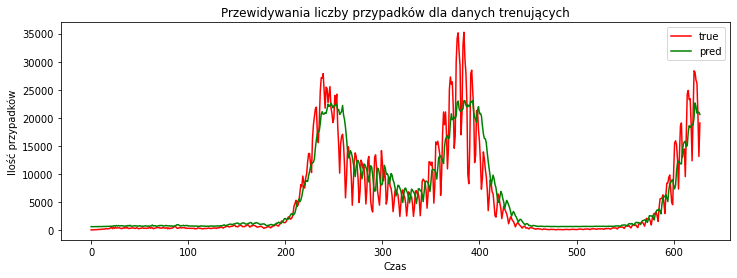

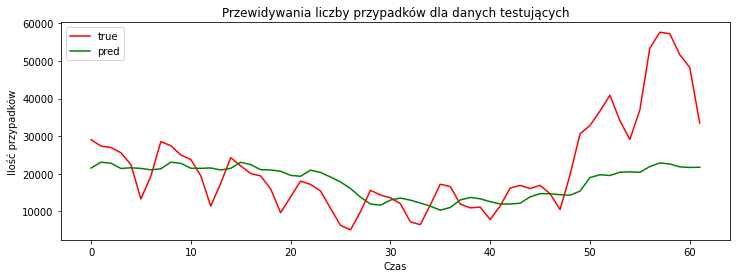

Coefficient of determination: 0.17530572
Index of agreement: 0.50068337
Recall: 1.0
Accuracy: 0.0


In [ ]:
X, y = prepare_X_y(train_data)

tscv = TimeSeriesSplit(n_splits=10)
#print(tscv)

for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

EarlyStop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1)

callbacks = [EarlyStop]

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

# Wypisanie predykowanych wartości w formie liczbowej
# X_pred = np.array(X_train[-1]).reshape(1,NR_DAYS,1).astype(float)
# print(X_pred * MAX_DATA)
# y_pred = model.predict(X_pred) * MAX_DATA
# print(y_pred.shape)
# print(y_pred)
# print(np.max(y_pred[0][-3:]))

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], "r--")
plt.plot(history.history['val_loss'], "g--")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.savefig('time_series_10_loss.png')
plt.show()

y_preds = prepare_preds(X_train)
draw_predictions(len(y_preds), y_train.reshape(len(y_preds)) * MAX_DATA, y_preds, "trenujących", "time_series_10_train.png")
y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących", "time_series_10_test.png")

y = y_test * MAX_DATA
y = np.reshape(y, len(y))
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
acc = accuracy_m(y, y_preds)
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Recall: ' + str(K.get_value(recall)))
print('Accuracy: ' + str(acc))

**Ilość podziałów: 8**

Epoch 1/50
20/20 [==============================] - 3s 130ms/step - loss: 0.0192 - val_loss: 0.0750
Epoch 2/50
20/20 [==============================] - 3s 128ms/step - loss: 0.0067 - val_loss: 0.0526
Epoch 3/50
20/20 [==============================] - 3s 127ms/step - loss: 0.0046 - val_loss: 0.0513
Epoch 4/50
20/20 [==============================] - 3s 127ms/step - loss: 0.0041 - val_loss: 0.0419
Epoch 5/50
20/20 [==============================] - 3s 129ms/step - loss: 0.0037 - val_loss: 0.0419
Epoch 6/50
20/20 [==============================] - 3s 127ms/step - loss: 0.0037 - val_loss: 0.0394
Epoch 7/50
20/20 [==============================] - 3s 130ms/step - loss: 0.0035 - val_loss: 0.0401
Epoch 8/50
20/20 [==============================] - 3s 129ms/step - loss: 0.0035 - val_loss: 0.0395
Epoch 9/50
20/20 [==============================] - 3s 126ms/step - loss: 0.0033 - val_loss: 0.0382
Epoch 10/50
20/20 [==============================] - 3s 128ms/step - loss: 0.0033 - val_loss: 0.0365

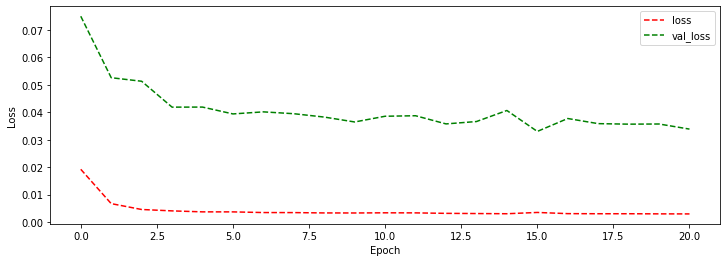

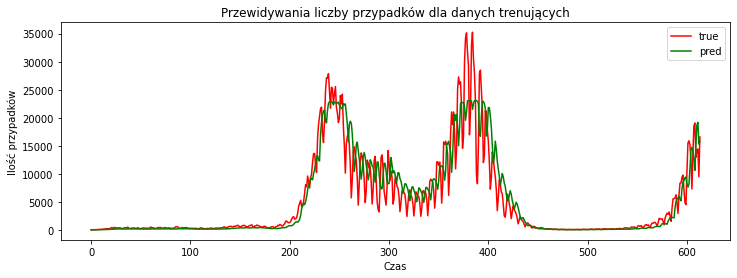

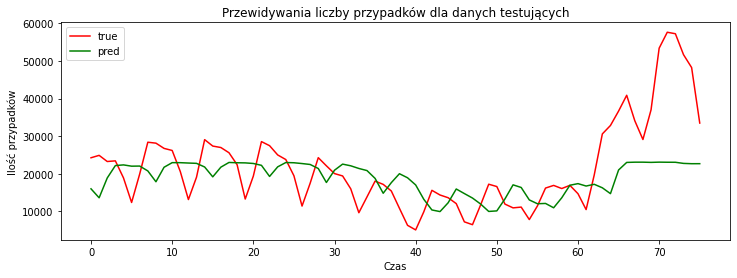

Coefficient of determination: 0.14643294
Index of agreement: 0.4847684
Recall: 1.0
Accuracy: 0.0


In [ ]:
X, y = prepare_X_y(train_data)

tscv = TimeSeriesSplit(n_splits=8)
#print(tscv)

for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

EarlyStop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1)

callbacks = [EarlyStop]

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

# Wypisanie predykowanych wartości w formie liczbowej
# X_pred = np.array(X_train[-1]).reshape(1,NR_DAYS,1).astype(float)
# print(X_pred * MAX_DATA)
# y_pred = model.predict(X_pred) * MAX_DATA
# print(y_pred.shape)
# print(y_pred)
# print(np.max(y_pred[0][-3:]))

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], "r--")
plt.plot(history.history['val_loss'], "g--")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.savefig('time_series_8_loss.png')
plt.show()

y_preds = prepare_preds(X_train)
draw_predictions(len(y_preds), y_train.reshape(len(y_preds)) * MAX_DATA, y_preds, "trenujących", "time_series_8_train.png")
y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących", "time_series_8_test.png")

y = y_test * MAX_DATA
y = np.reshape(y, len(y))
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
acc = accuracy_m(y, y_preds)
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Recall: ' + str(K.get_value(recall)))
print('Accuracy: ' + str(acc))

**Ilość podziałów: 2**

Epoch 1/50
15/15 [==============================] - 2s 162ms/step - loss: 0.0276 - val_loss: 0.0210
Epoch 2/50
15/15 [==============================] - 2s 150ms/step - loss: 0.0060 - val_loss: 0.0183
Epoch 3/50
15/15 [==============================] - 2s 168ms/step - loss: 0.0049 - val_loss: 0.0143
Epoch 4/50
15/15 [==============================] - 2s 158ms/step - loss: 0.0039 - val_loss: 0.0137
Epoch 5/50
15/15 [==============================] - 3s 179ms/step - loss: 0.0033 - val_loss: 0.0127
Epoch 6/50
15/15 [==============================] - 2s 158ms/step - loss: 0.0035 - val_loss: 0.0132
Epoch 7/50
15/15 [==============================] - 2s 159ms/step - loss: 0.0034 - val_loss: 0.0120
Epoch 8/50
15/15 [==============================] - 3s 173ms/step - loss: 0.0034 - val_loss: 0.0116
Epoch 9/50
15/15 [==============================] - 2s 169ms/step - loss: 0.0033 - val_loss: 0.0115
Epoch 10/50
15/15 [==============================] - 2s 168ms/step - loss: 0.0033 - val_loss: 0.0114

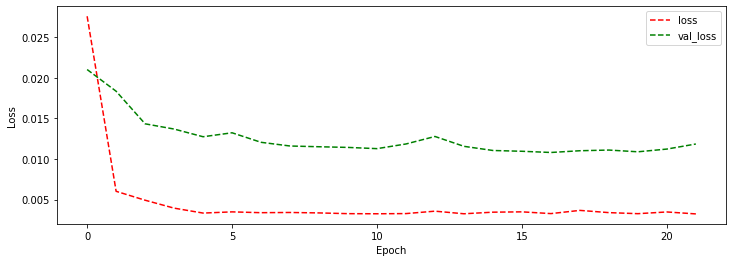

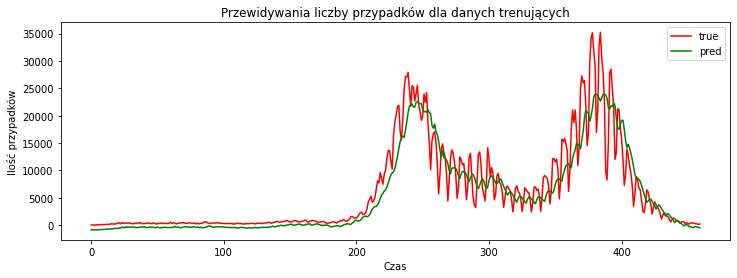

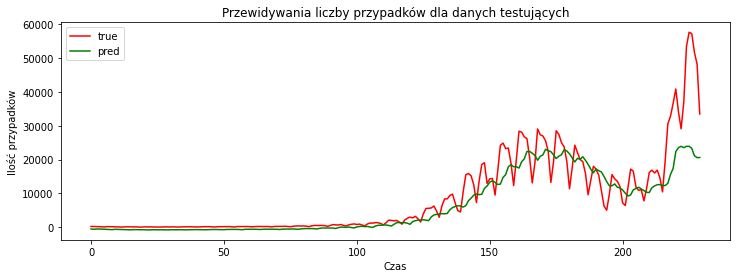

Coefficient of determination: 0.7175181
Index of agreement: 0.9004045
Recall: 0.57391304
Accuracy: 0.0


In [ ]:
X, y = prepare_X_y(train_data)

tscv = TimeSeriesSplit(n_splits=2)
#print(tscv)

for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

EarlyStop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1)

callbacks = [EarlyStop]

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

# Wypisanie predykowanych wartości w formie liczbowej
# X_pred = np.array(X_train[-1]).reshape(1,NR_DAYS,1).astype(float)
# print(X_pred * MAX_DATA)
# y_pred = model.predict(X_pred) * MAX_DATA
# print(y_pred.shape)
# print(y_pred)
# print(np.max(y_pred[0][-3:]))

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], "r--")
plt.plot(history.history['val_loss'], "g--")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.savefig('time_series_2_loss.png')
plt.show()

y_preds = prepare_preds(X_train)
draw_predictions(len(y_preds), y_train.reshape(len(y_preds)) * MAX_DATA, y_preds, "trenujących", "time_series_2_train.png")
y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących", "time_series_2_test.png")

y = y_test * MAX_DATA
y = np.reshape(y, len(y))
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
acc = accuracy_m(y, y_preds)
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Recall: ' + str(K.get_value(recall)))
print('Accuracy: ' + str(acc))